In [1]:
import math
from pathlib import Path
import numpy as np 
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm

# Local modules
from modules import preprocessing

### Dataset: Importing images and annotations

In [2]:
DATASET_PATH = Path("datasets/dataset/train")

In [3]:
img_paths = list(DATASET_PATH.glob("**/*.bmp"))
ann_paths = list(DATASET_PATH.glob("**/*.txt"))

In [4]:
img_paths[0]


WindowsPath('datasets/dataset/train/img180cl_000.bmp')

### Viewing image

In [5]:
img = cv2.imread(str(img_paths[0]), 0)

In [6]:
img.shape

(128, 128)

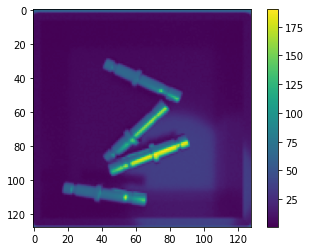

In [7]:
plt.imshow(img, cmap="viridis")
plt.colorbar()
plt.show()

### Preprocessing

In [16]:
num = 10
test_image = cv2.imread(str(img_paths[num]))
test_annot = preprocessing.preprocess_annot(ann_paths[num],
test_image.shape)

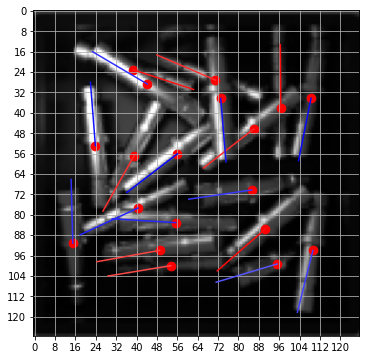

In [17]:
preprocessing.draw_annot(test_image, test_annot)

In [ ]:
test_annot.shape

In [ ]:
param = 1
print("Max value: ", max(test_annot[:, param]))
print("Min value: ", min(test_annot[:, param]))

## read_annotation

In [ ]:
min = 0
max = 1
for num in range(len(ann_paths)):
    test_annot = preprocessing.preprocess_annot(ann_paths[num],
test_image.shape)
    if np.max(test_annot[:, 3]) > max:
        max = np.max(test_annot[:, 3])
    if np.max(test_annot[:, 3]) < min:
        min = np.min(test_annot[:, 3])

print(max, min)

## Creating a test model

In [35]:
def create_model(input_width, input_height):    
    # labels = list(labels)
    # nb_class = len(labels)

    # number of classes in the dataset
    nb_class = 1
    # predefined number of keypoint pairs per grid cell, here always 1, can be removed
    nb_kpp = 3

    # class_wt = np.ones(nb_class, dtype='float32')
    # max_kpp_per_image = 1  # kpp = key point pairs
    # seen = 0

    # make the feature extractor layers
    # Input image with height, width and image with only one channel
    input_image = tf.keras.Input(shape=(input_height, input_width, 1))

    num_layer = 0  # intial layers assigned as 0

    # stack 1
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same',
                name='conv_' + str(num_layer), use_bias=False)(input_image)
    x = tf.keras.layers.BatchNormalization(name='norm_' + str(num_layer))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    # x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    num_layer += 1

    # stack 3
    for i in range(0, 10):
        x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same',
                    name='conv_' + str(num_layer), use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization(name='norm_' + str(num_layer))(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
        num_layer += 1

    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                name='conv_' + str(num_layer), use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization(name='norm_' + str(num_layer))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    num_layer += 1

    for i in range(0, 10):
        x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same',
                    name='conv_' + str(num_layer), use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization(name='norm_' + str(num_layer))(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
        num_layer += 1

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same',
                name='conv_' + str(num_layer), use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization(name='norm_' + str(num_layer))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    num_layer += 1

    for i in range(0, 10):
        x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same',
                    name='conv_' + str(num_layer), use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization(name='norm_' + str(num_layer))(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
        num_layer += 1

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same',
                name='conv_' + str(num_layer), use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization(name='norm_' + str(num_layer))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    num_layer += 1

    x = tf.keras.layers.Conv2D(nb_kpp * (4+1 + nb_class),
                (3, 3),
                strides=(1, 1),
                padding='same', name='conv_'+str(num_layer), use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization(name='norm_' + str(num_layer))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    num_layer += 1

    # # make the object detection layer
    # output = tf.keras.layers.Conv2D(nb_kpp * (4 + 1 + nb_class),  # (x, y, ex, ey, conf, no.of classes)
    #                 (1, 1),
    #                 strides=(1, 1),
    #                 padding='same',
    #                 name='DetectionLayer',
    #                 kernel_initializer='lecun_normal')(x)

    print("x.shape=", x.shape.as_list())
    # print("output.shape=", output.shape.as_list())
    grid_h = x.shape.as_list()[1]
    grid_w = x.shape.as_list()[2]

    print("grid_h, grid_w=", grid_h, grid_w)

    # output = tf.keras.layers.Reshape((grid_h, grid_w, nb_kpp, 4 + 1 + nb_class))(x)

    output = tf.keras.layers.Reshape((grid_h, grid_w, nb_kpp *( 4 + 1 + nb_class)))(x)

    # print("output shape at reshaping", output.shape)

    print("model_1 input shape=", input_image.shape)
    print("model_2 output shape=", output.shape)

    model = tf.keras.Model(inputs=input_image, outputs=output)

    return model


In [36]:
model = create_model(128, 128)

x.shape= [None, 16, 16, 18]
grid_h, grid_w= 16 16
model_1 input shape= (None, 128, 128, 1)
model_2 output shape= (None, 16, 16, 18)


In [37]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 128, 128, 64)      576       
_________________________________________________________________
norm_0 (BatchNormalization)  (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 128, 128, 64)      36864     
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0     

## Testing with loaded data

In [42]:
num_samples = 10
img_w = 128
img_h = 128
grid_w = 8
grid_h = 8

# array to store annotation samples
img_for_train = np.zeros([num_samples, 128, 128, 1])
annot_for_train = np.zeros([num_samples, 16, 16, 18])
print(annot_for_train.shape)

for num in range(num_samples):
    img_for_train[num, :, :, 0] = cv2.imread(str(img_paths[num]), 0)
    test_annot = preprocessing.preprocess_annot(ann_paths[num],
    test_image.shape)

    sector_x = test_annot[:, 1] // grid_w
    sector_y = test_annot[:, 2] // grid_h

    for i, (sec_x, sec_y) in enumerate(zip(sector_x, sector_y)):
        # print(sec_x, sec_y)

        annot_for_train[num, int(sec_x), int(sec_y), 0] = (test_annot[i, 1] - grid_w * sec_x) / grid_w # x_0
        annot_for_train[num, int(sec_x), int(sec_y), 1] = (test_annot[i, 2] - grid_h * sec_y) / grid_h # y_0
        annot_for_train[num, int(sec_x), int(sec_y), 2] = 2*(math.sin(test_annot[i, 3]))**2 # I_x
        annot_for_train[num, int(sec_x), int(sec_y), 3] = 2*(math.sin(test_annot[i, 4]) * math.cos(test_annot[i, 4])) # I_y
        annot_for_train[num, int(sec_x), int(sec_y), 4] = test_annot[i, 5] + test_annot[i, 6] # conf_1 + conf_2
        annot_for_train[num, int(sec_x), int(sec_y), 5] = test_annot[i, 0] # class

(10, 16, 16, 18)


## Fit to model

In [47]:
model.compile(optimizer="adam")

In [48]:
model.fit(x=img_for_train, y=annot_for_train, epochs=1)

ValueError: in user code:

    C:\Users\jayak\anaconda3\envs\tf-env\lib\site-packages\tensorflow\python\keras\engine\training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\jayak\anaconda3\envs\tf-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\jayak\anaconda3\envs\tf-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\jayak\anaconda3\envs\tf-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\jayak\anaconda3\envs\tf-env\lib\site-packages\tensorflow\python\keras\engine\training.py:540 train_step  **
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    C:\Users\jayak\anaconda3\envs\tf-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1803 _minimize
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
    C:\Users\jayak\anaconda3\envs\tf-env\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:521 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    C:\Users\jayak\anaconda3\envs\tf-env\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:1218 _filter_grads
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['conv_0/kernel:0', 'norm_0/gamma:0', 'norm_0/beta:0', 'conv_1/kernel:0', 'norm_1/gamma:0', 'norm_1/beta:0', 'conv_2/kernel:0', 'norm_2/gamma:0', 'norm_2/beta:0', 'conv_3/kernel:0', 'norm_3/gamma:0', 'norm_3/beta:0', 'conv_4/kernel:0', 'norm_4/gamma:0', 'norm_4/beta:0', 'conv_5/kernel:0', 'norm_5/gamma:0', 'norm_5/beta:0', 'conv_6/kernel:0', 'norm_6/gamma:0', 'norm_6/beta:0', 'conv_7/kernel:0', 'norm_7/gamma:0', 'norm_7/beta:0', 'conv_8/kernel:0', 'norm_8/gamma:0', 'norm_8/beta:0', 'conv_9/kernel:0', 'norm_9/gamma:0', 'norm_9/beta:0', 'conv_10/kernel:0', 'norm_10/gamma:0', 'norm_10/beta:0', 'conv_11/kernel:0', 'norm_11/gamma:0', 'norm_11/beta:0', 'conv_12/kernel:0', 'norm_12/gamma:0', 'norm_12/beta:0', 'conv_13/kernel:0', 'norm_13/gamma:0', 'norm_13/beta:0', 'conv_14/kernel:0', 'norm_14/gamma:0', 'norm_14/beta:0', 'conv_15/kernel:0', 'norm_15/gamma:0', 'norm_15/beta:0', 'conv_16/kernel:0', 'norm_16/gamma:0', 'norm_16/beta:0', 'conv_17/kernel:0', 'norm_17/gamma:0', 'norm_17/beta:0', 'conv_18/kernel:0', 'norm_18/gamma:0', 'norm_18/beta:0', 'conv_19/kernel:0', 'norm_19/gamma:0', 'norm_19/beta:0', 'conv_20/kernel:0', 'norm_20/gamma:0', 'norm_20/beta:0', 'conv_21/kernel:0', 'norm_21/gamma:0', 'norm_21/beta:0', 'conv_22/kernel:0', 'norm_22/gamma:0', 'norm_22/beta:0', 'conv_23/kernel:0', 'norm_23/gamma:0', 'norm_23/beta:0', 'conv_24/kernel:0', 'norm_24/gamma:0', 'norm_24/beta:0', 'conv_25/kernel:0', 'norm_25/gamma:0', 'norm_25/beta:0', 'conv_26/kernel:0', 'norm_26/gamma:0', 'norm_26/beta:0', 'conv_27/kernel:0', 'norm_27/gamma:0', 'norm_27/beta:0', 'conv_28/kernel:0', 'norm_28/gamma:0', 'norm_28/beta:0', 'conv_29/kernel:0', 'norm_29/gamma:0', 'norm_29/beta:0', 'conv_30/kernel:0', 'norm_30/gamma:0', 'norm_30/beta:0', 'conv_31/kernel:0', 'norm_31/gamma:0', 'norm_31/beta:0', 'conv_32/kernel:0', 'norm_32/gamma:0', 'norm_32/beta:0', 'conv_33/kernel:0', 'norm_33/gamma:0', 'norm_33/beta:0', 'conv_34/kernel:0', 'norm_34/gamma:0', 'norm_34/beta:0'].
